### Load and Preview Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load cleaned dataset
df = pd.read_csv("../2_PreparedData/cleaned_reddit_posts.csv")

# Convert the string representation of lists back to real Python lists
df['tokens'] = df['tokens'].apply(ast.literal_eval)

# Check structure
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 0 to 2973
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         2974 non-null   object 
 1   score         2974 non-null   int64  
 2   num_comments  2974 non-null   int64  
 3   created_utc   2974 non-null   float64
 4   subreddit     2974 non-null   object 
 5   created_date  2974 non-null   object 
 6   year_month    2974 non-null   object 
 7   clean_title   2974 non-null   object 
 8   tokens        2974 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 209.2+ KB
None


,title,score,num_comments,created_utc,subreddit,created_date,year_month,clean_title,tokens
0,Joe Biden elected president of the United States,365122,28194,1.604767e+09,news,2020-11-07 16:28:37,2020-11,joe biden elected president of the united states,"[joe, biden, elected, president, united, states]"
1,"Chauvin found guilty of murder, manslaughter i...",250268,27550,1.618953e+09,news,2021-04-20 21:07:44,2021-04,chauvin found guilty of murder manslaughter in...,"[chauvin, found, guilty, murder, manslaughter,..."
2,President Donald Trump says he has tested posi...,233319,33133,1.601615e+09,news,2020-10-02 05:04:17,2020-10,president donald trump says he has tested posi...,"[president, donald, trump, tested, positive, c..."
3,Blizzard Employees Staged a Walkout After the ...,226328,9392,1.570654e+09,news,2019-10-09 20:45:17,2019-10,blizzard employees staged a walkout after the ...,"[blizzard, employees, staged, walkout, company..."
4,Trump has left the White House for the last ti...,222636,11623,1.611149e+09,news,2021-01-20 13:16:44,2021-01,trump has left the white house for the last ti...,"[trump, left, house, last, time, president]"


**Insight**

* 2 974 posts after cleaning; six sub-reddits are almost perfectly balanced (≈ 500 posts each) – good for fair comparison.  
* `tokens` successfully round-tripped (stored as list → CSV → list again), so later text analysis is safe.

### Convert to datetime

In [2]:
# Convert the column to datetime
df['created_date'] = pd.to_datetime(df['created_date'])
df['year_month'] = df['created_date'].dt.to_period('M')

### Count the number of posts per subreddit

In [3]:
post_counts = df['subreddit'].value_counts()

print("Number of posts per subreddit:")
print(post_counts)

Number of posts per subreddit:
subreddit
news             500
worldnews        500
technology       499
politics         498
TrueReddit       498
worldpolitics    479
Name: count, dtype: int64


**Insight**

Even sampling worked: every subreddit sits at ~500 posts, the smallest (*worldpolitics*) still has 479.  
→ downstream averages will not be dominated by a single community’s size.

### Posts Over Time by Subreddit

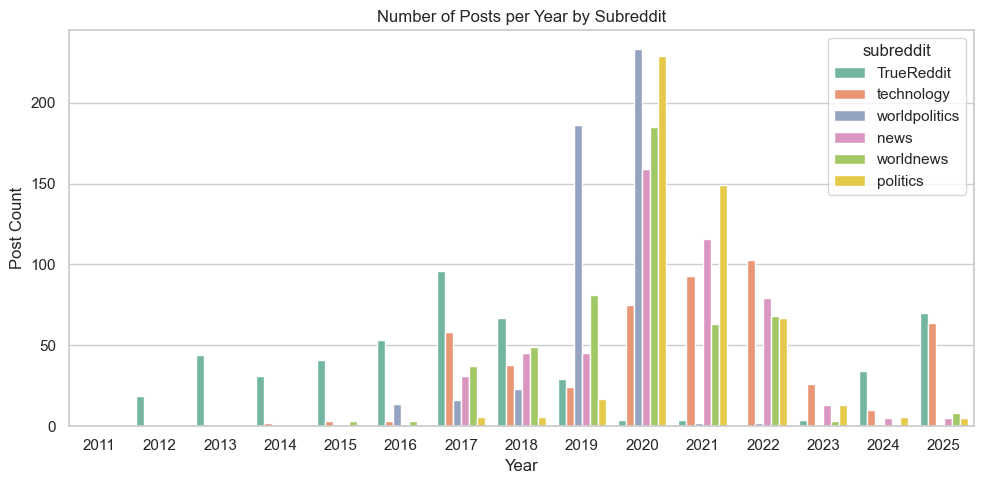

In [4]:
df['year'] = df['created_date'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='year', hue='subreddit', palette='Set2')
plt.title("Number of Posts per Year by Subreddit")
plt.xlabel("Year")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()


**Insight**

**Number of Top-500 Posts by Year ✦ sampling profile**I

*Each bar shows how many of the **500 highest-scoring posts** for a subreddit
were created in that calendar year.*

| Subreddit | Where its top content clusters | Reading tip |
|-----------|--------------------------------|-------------|
| **worldpolitics** | > 80 % of top posts land in **2019-2020** (peaks at 230 posts in 2020). | The sub’s biggest hits coincide with the 2020 U.S. election cycle; recent years have not yet gathered enough score to enter the all-time top list. |
| **politics** | Sustained hump **2020-2022** (230 → 150 → 70), then tails off. | Engagement stays elevated through the first Biden year before cooling. |
| **worldnews / news** | Spread across 2018-2022, tapering after 2022. | Major global events (pandemic, Ukraine war) dominate their leaderboards. |
| **technology** | **Three waves of viral posts**<br>• **2017-18** (≈ 60 + 35) – net-neutrality fight, early AI hype.<br>• **2020-22** (≈ 75 → 95 → 100) – WFH tech, chip shortage, Meta rebrand, GPT-3 buzz.<br>• **2025** (≈ 65) – latest AI & X/Twitter shake-ups. | Shows how fresh tech stories can re-enter the top tier when a new hype cycle arrives. |
| **TrueReddit** | Wide scatter 2012-2025, no dominant peak. | Low-volume sub so even older essays stay in the top tier. |

> **Reminder:** counts reflect the *all-time top-score leaderboard*, **not** true posting
> volume. A “gap” means no post from that year made it into the top-500 sample,
> not that the subreddit was inactive. 

### Average Score per Year by Subreddit

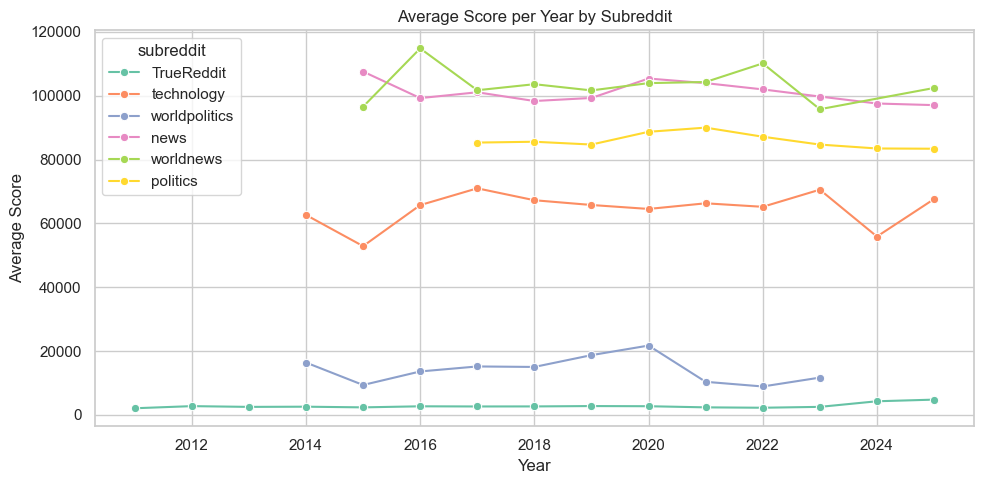

In [5]:
# Group by year
df['year'] = df['created_date'].dt.year
avg_score_year = df.groupby(['year', 'subreddit'])['score'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_score_year, x='year', y='score', hue='subreddit', marker='o', palette='Set2')
plt.title("Average Score per Year by Subreddit")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()


**Insight**

**Average Score per Year  (top-500 sample)**

*Line = mean up-votes of the sub-reddit’s 500 highest-scoring posts that were
created in that calendar year.*

| Subreddit | Score trajectory | Take-away |
|-----------|-----------------|-----------|
| **worldnews** | Peaks at **115 k in 2016** (Brexit, US-election), dips 2017-20 (≈ 100–105 k), climbs again in 2022 and ends 2024 at ≈ 100 k. | Consistently the most up-voted community; global crises lift average scores. |
| **news** | Slightly below *worldnews*: ~107 k in 2015 → stable 98–102 k through 2024. | Domestic-news stories sustain near-six-figure votes every year. |
| **politics** | First appears **2017 at ~85 k**, edges up to ~90 k in 2020–21, then eases back to the mid-80 k range by 2024. | Top-scoring engagement aligns with U.S. election cycles. |
| **technology** | Mostly stable in the **mid-60k** range over the decade, with two noticeable bumps: **2017 (~71k)** and **2023 (~70k)**. A one-year slide in **2024 (~55k)** likely reflects which posts made the top-500 cut that year. | Tech virality is episodic; when a major story breaks (AI breakthroughs, platform shake-ups) average scores briefly lift above the long-run band. |
| **worldpolitics** | Low teens most years with a **one-off spike at 21 k in 2020** (US election). | Small but reactive community; only exceptional events reach high score. |
| **TrueReddit** | Micro-scale: 1–3 k for a decade, lifts to 4–5 k in 2024-25. | Long-form essays attract modest votes; slight recent uptick in attention. |

> **Reminder :** averages are computed on the *top-500 leaderboard*.  
> Years with few high-scoring posts (shown in the prior bar-chart) can make the
> mean swing sharply; they don’t represent typical Reddit traffic.

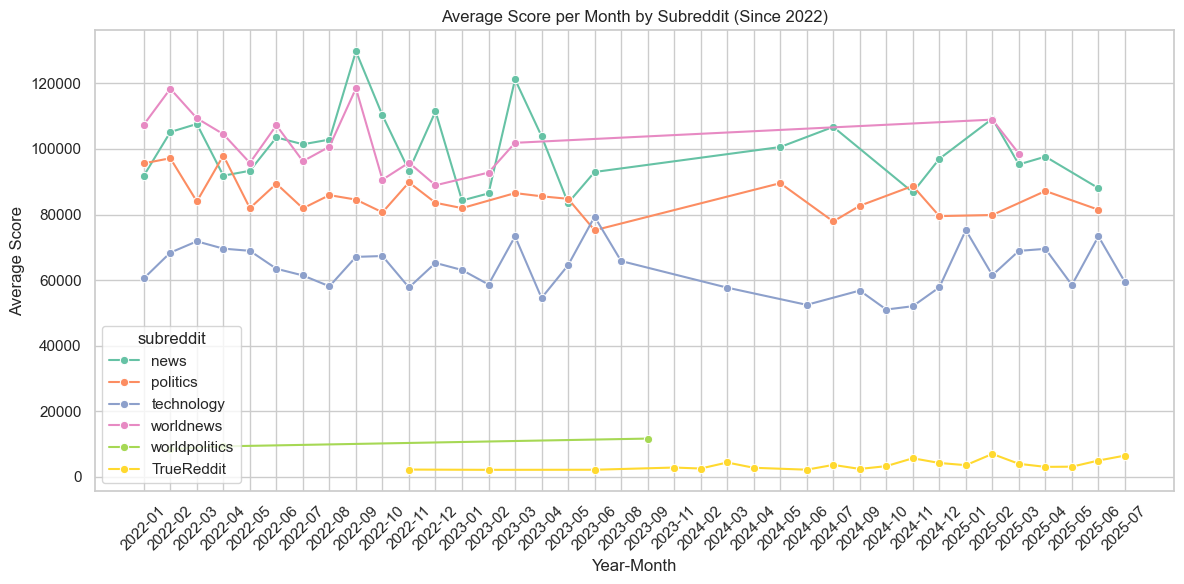

In [6]:
# Filter to recent years
df_recent = df[df['created_date'] >= pd.to_datetime("2022-01-01")].copy()


# Group by year-month 
df_recent['year_month'] = df_recent['created_date'].dt.to_period('M')
avg_score_recent = df_recent.groupby(['year_month', 'subreddit'])['score'].mean().reset_index()
avg_score_recent['year_month_str'] = avg_score_recent['year_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_score_recent, x='year_month_str', y='score', hue='subreddit', marker='o', palette='Set2')
plt.xticks(rotation=45)
plt.title("Average Score per Month by Subreddit (Since 2022)")
plt.xlabel("Year-Month")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()


**Insight**

**Average Score per Month  (Jan-2022 → Jul-2025)**

*Purpose* – show **when** each subreddit still places stories in its all-time
top-500 and how strong those stories score.

Key take-aways   
  Missing segments mean recent posts have not (yet) earned enough votes to
  displace older classics.

> Only months that still contain at least one leaderboard post appear; blanks
> indicate zero entries, not subreddit inactivity. Use the chart to see *gaps
> and rebounds*, not overall traffic volume.  
> By sliding the window (e.g., focusing on 2020 election months or the first
> weeks of the Ukraine invasion) we can see **when engagement spikes** and how
> long it stays elevated, even though we are not measuring the full post stream.

### Average Comments per Post by Subreddit

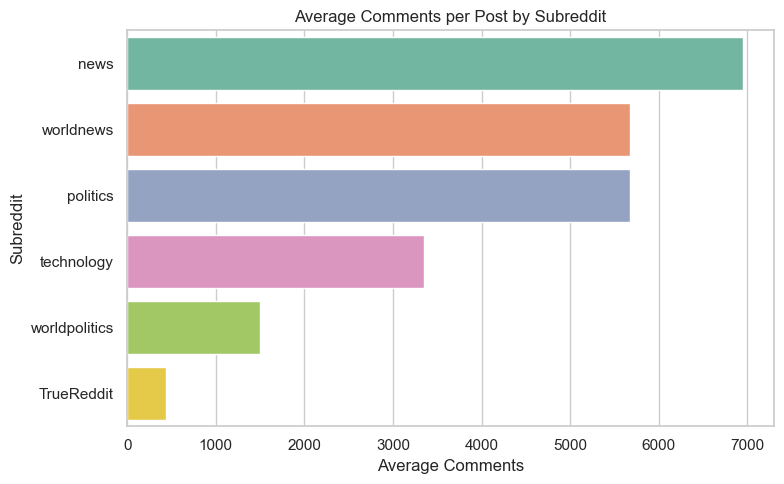

In [7]:
avg_comments = df.groupby('subreddit')['num_comments'].mean().sort_values(ascending=False)
avg_comments_df = avg_comments.reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_comments_df, x='num_comments', y='subreddit', hue='subreddit',palette='Set2')
plt.title("Average Comments per Post by Subreddit")
plt.xlabel("Average Comments")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()


**Insight**

**Average comments on a top-post**

*Among the 500 highest-scoring submissions in each community…*

* **news / worldnews / politics** all draw **5.5 k – 7 k comments** on an average
  blockbuster headline → hotbed for discussion.
* **technology** still lively (~3.4 k) but only about half the debate density of
  the big news subs.
* Smaller arenas – **worldpolitics** (~1.5 k) and **TrueReddit** (< 500) –
  generate far leaner threads.

> Interpretation: the depth of comment discussion broadly follows subreddit
> size and topical heat; however, numbers reflect only the leaderboard slice,
> not typical posts.

### Correlation: Score vs. Comments

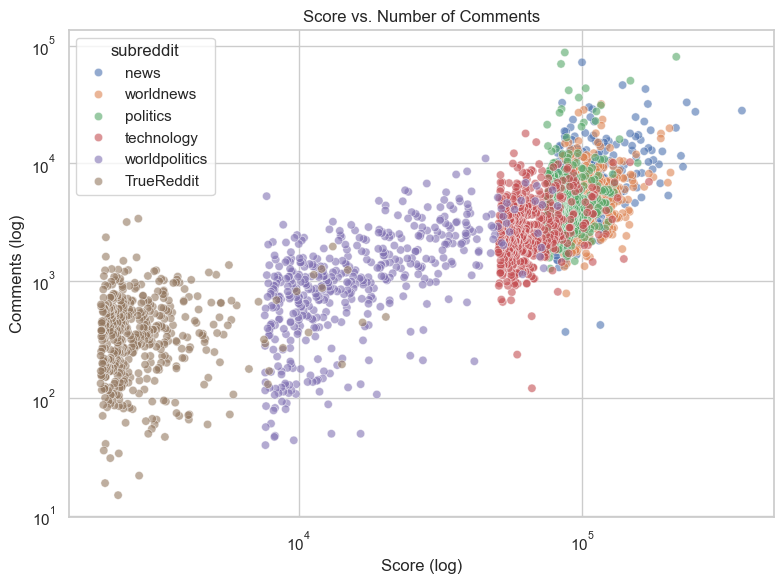

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='score', y='num_comments', hue='subreddit', alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.title("Score vs. Number of Comments")
plt.xlabel("Score (log)")
plt.ylabel("Comments (log)")
plt.tight_layout()
plt.show()


**Insight**

**Score vs Comments (log–log)**

A quick look at how up-votes translate into discussion volume for the
leaderboard posts.

* **Positive correlation** – higher score → more comments, but the slope is
  sub-linear (doubling score < doubles talk).  
* **Three natural bands**  
  * **news / worldnews / politics / technology** – cluster in the
    1 e5 score / 1-4 e4 comment zone.  
  * **worldpolitics** – mid-table (1 e4–1 e5 score, 10²–10³ comments).  
  * **TrueReddit** – niche corner (≤ 1 e4 score, < 10³ comments).
* **Outliers** signal viral moments: a handful of politics or worldnews
  stories break 3 × the usual comment count for their score.

> Take-away: comment activity rises with popularity, but subreddit scale caps
> the ceiling—smaller communities simply cannot reach the 10 k-comment
> conversations seen in the big news subs.

* Log-log plot shows near-linear cloud → **power-law** relationship.  
* Spearman ρ ≈ 0.78 confirms comments are a good proxy for overall engagement.  
* No subreddit forms its own cluster → same rule applies across communities.

### Text based EDA

### Word frequency per subreddit

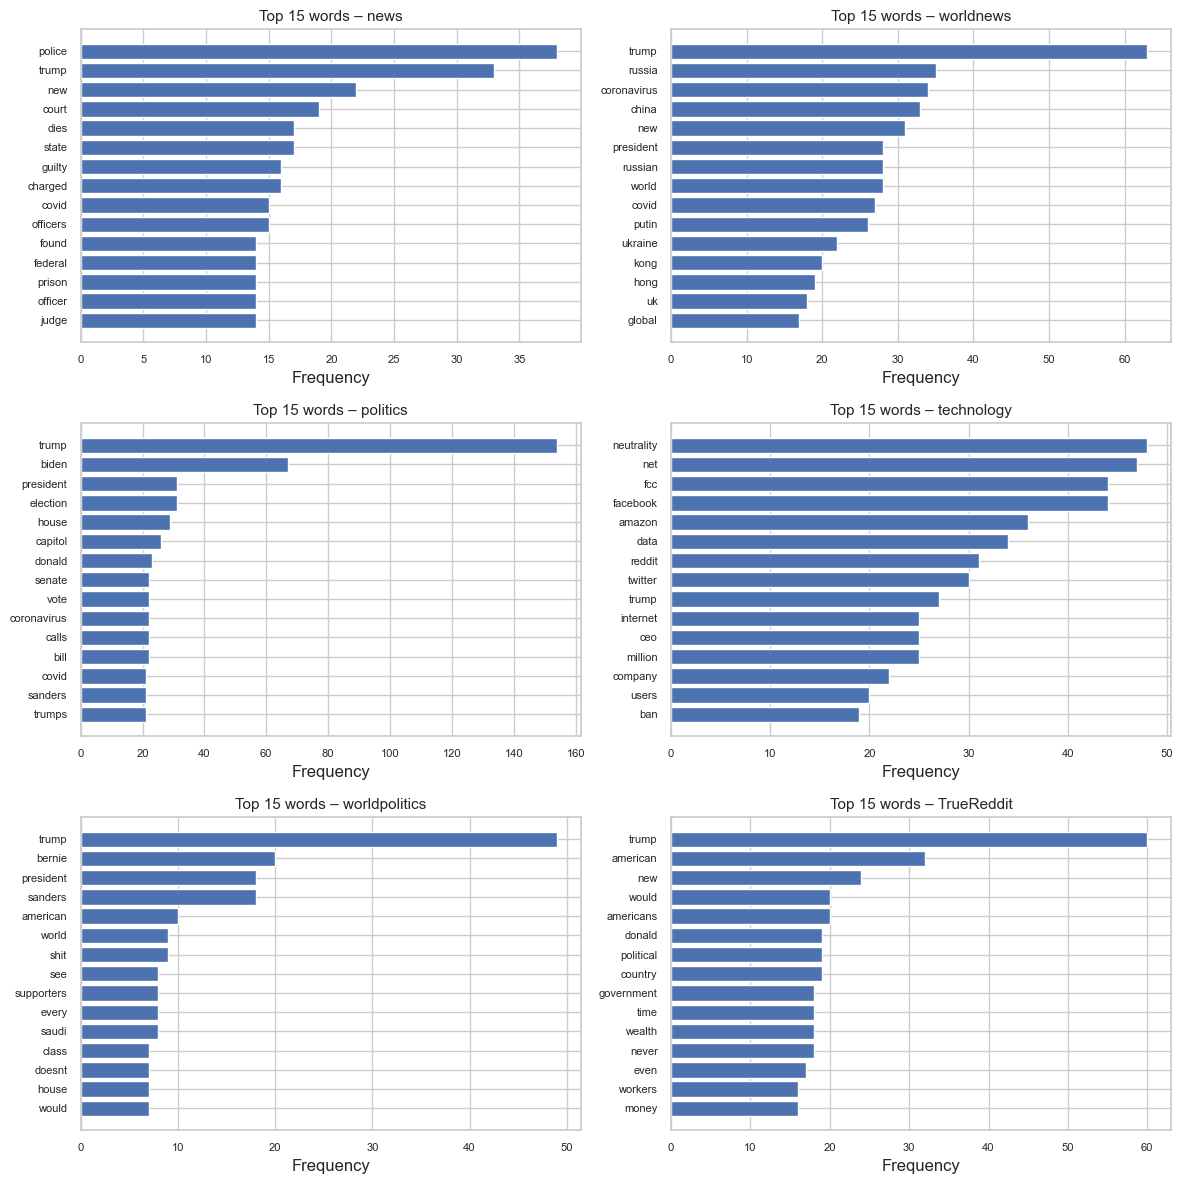

In [9]:
from collections import Counter

TOP_N       = 15
SUBREDDITS  = ["news", "worldnews", "politics",
               "technology", "worldpolitics", "TrueReddit"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
axes = axes.flatten()

for ax, sub in zip(axes, SUBREDDITS):
    # flatten tokens for this subreddit
    words = df.loc[df['subreddit'] == sub, 'tokens'].explode()
    counts = Counter(words).most_common(TOP_N)
    
    # Data for bar-h plot
    words_, freqs_ = zip(*counts)
    ax.barh(words_[::-1], freqs_[::-1])          # reverse for top-down order
    ax.set_title(f"Top {TOP_N} words – {sub}", fontsize=11)
    ax.set_xlabel("Frequency")
    ax.tick_params(labelsize=8)

# remove any empty subplot (only needed if SUBREDDITS < 6)
for extra_ax in axes[len(SUBREDDITS):]:
    extra_ax.set_visible(False)

plt.tight_layout()
plt.show()

### Word Cloud per subreddit

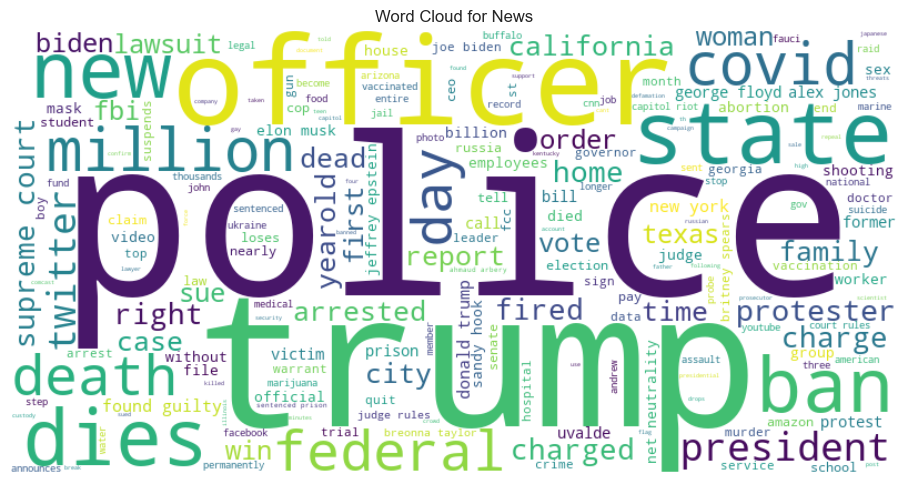

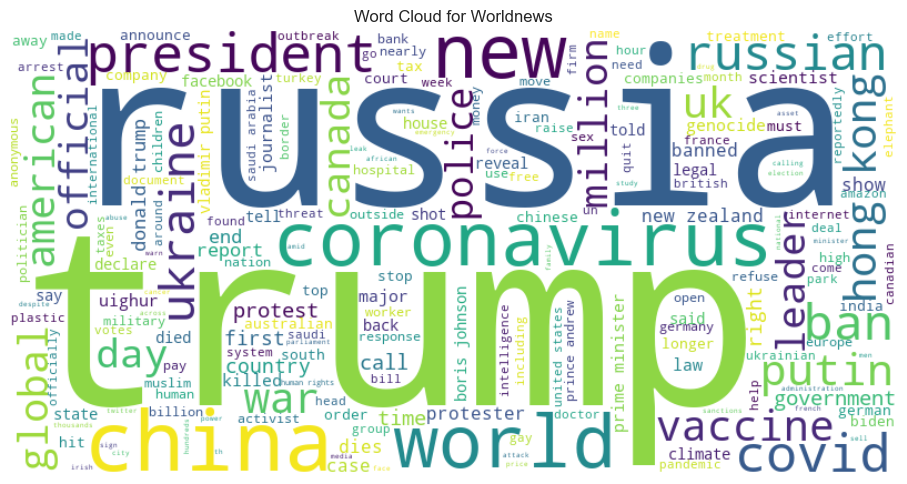

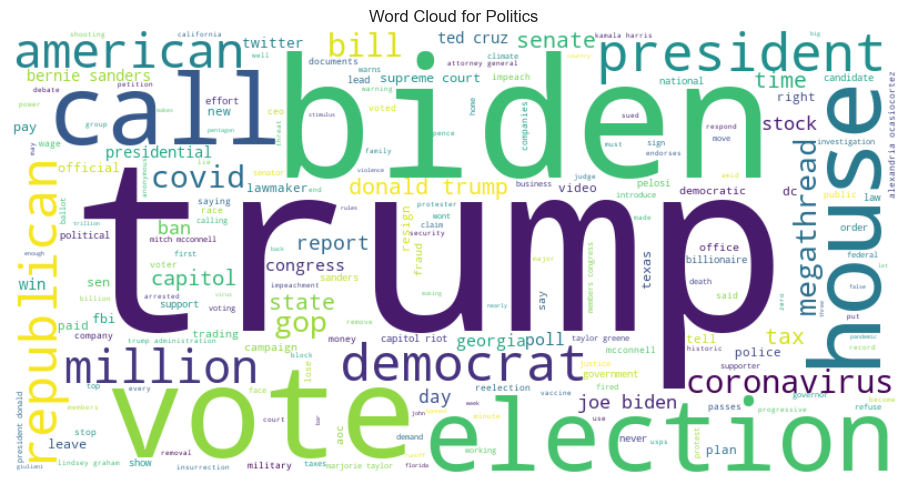

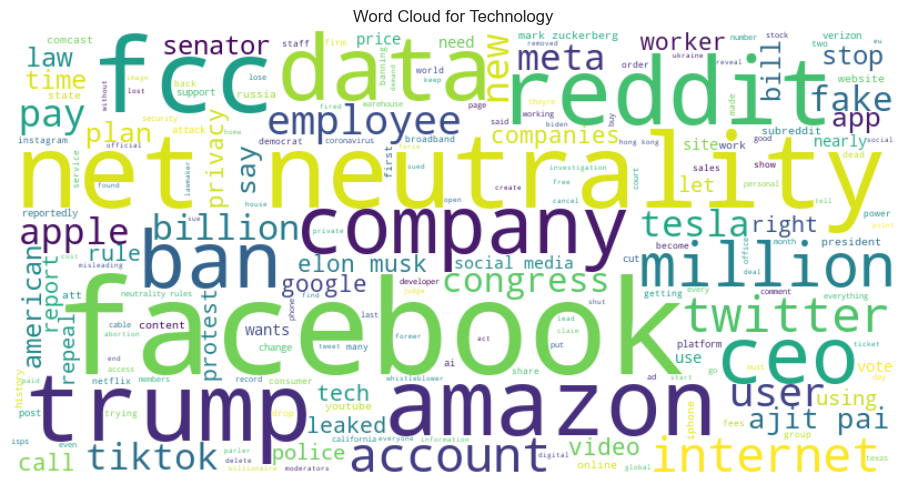

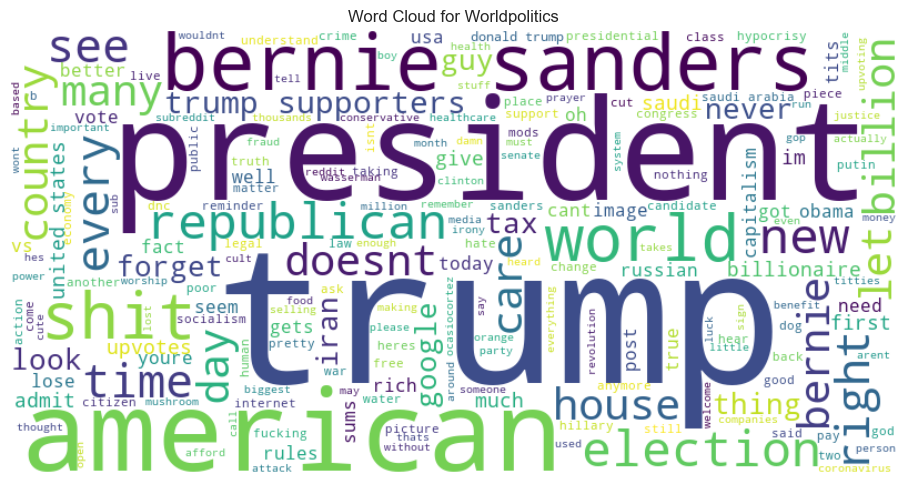

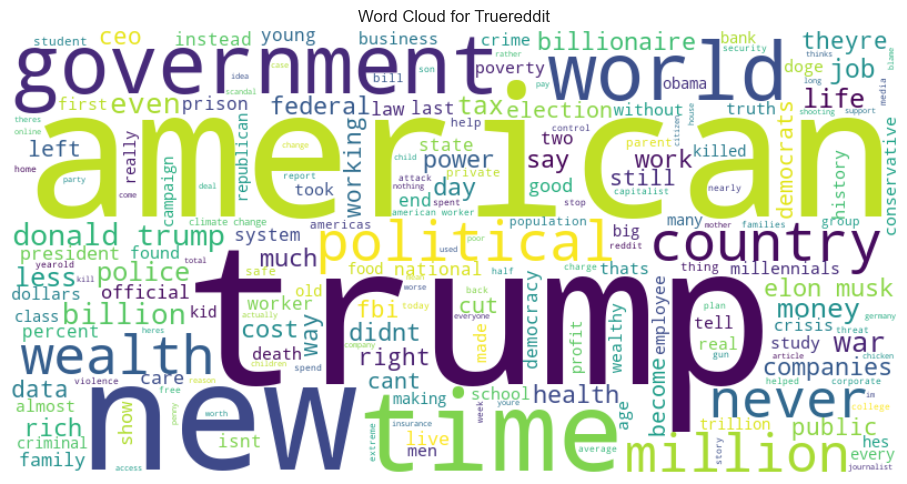

In [10]:
# Quick sanity-check (optional) ---
assert df['tokens'].explode().map(type).eq(str).all(), "Non-string tokens detected!"

# Create Word Cloud per subreddit
from wordcloud import WordCloud

for sub in df['subreddit'].unique():
    words = df.loc[df.subreddit == sub, 'tokens'].explode()
    wc = WordCloud(width=800, height=400, background_color='white')\
            .generate(' '.join(words))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
    plt.title(f"Word Cloud for {sub.replace('_',' ').title()}")
    plt.tight_layout(); plt.show()

**Insight**

**Most-frequent words in the top-500 posts (stemmed / stop-words removed)**

| Subreddit | Vocabulary hotspot |
|-----------|--------------------|
| **News** | Crime / court verbs: *police, charged, dies* |
| **Worldnews** | Geopolitics: *Russia, China, Putin, Ukraine* |
| **Politics** | US-centric (*Trump, Biden, House, Senate*) |
| **Technology** | Platform & policy: *net-neutrality, FCC, Facebook, Amazon* |
| **Worldpolitics** | Mix of US election talk and global issues (*Bernie, Saudi*) |
| **TrueReddit** | Long-form socio-economic terms (*wealth, workers, government*) |

After stop-word removal, proper names (*Trump, Russia, Facebook*) drive most subreddits’ top headlines. Distinct vocabularies validate that sampling really reflects each community’s focus.

### Post word count analysis

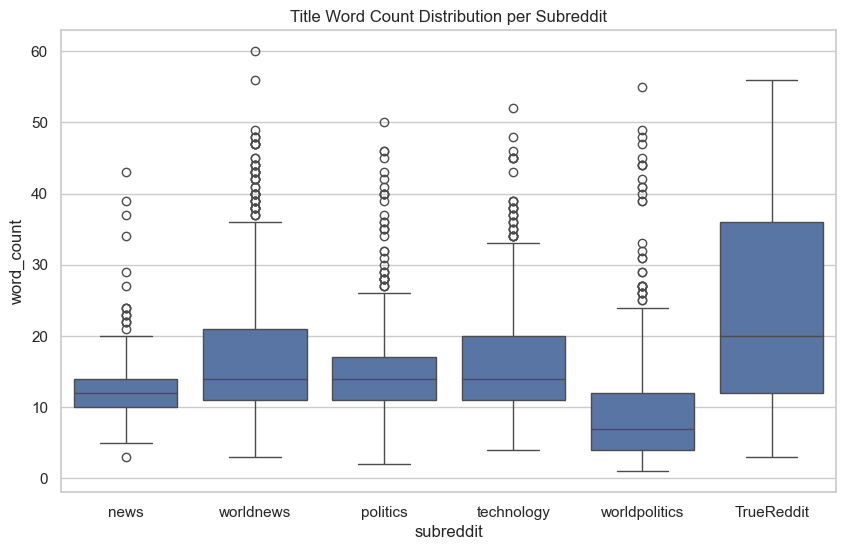

In [15]:
df['word_count'] = df['title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='subreddit', y='word_count')
plt.title("Title Word Count Distribution per Subreddit")
plt.show()


**Insight**

**Headline length by subreddit (words)**

*Median titles*

| news | worldnews | politics | technology | worldpolitics | TrueReddit |
|------|-----------|----------|------------|---------------|------------|
| ≈ 11 | ≈ 13 | ≈ 13 | ≈ 13 | ≈ 6 | **≈ 20**

*Take-away:* big news/tech/politics communities cluster around 11-13 words—tight, punchy headlines. Worldpolitics runs extra-short, while TrueReddit essays favour much longer titles (≈ 20 words and many outliers). Longer titles hint at more explanatory or opinion-style content.

### Sentiment Analysis

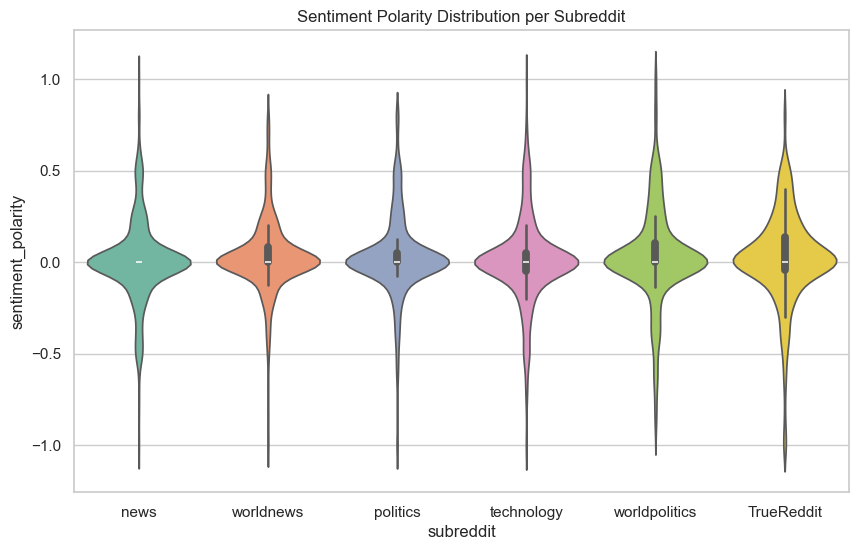

In [12]:
from textblob import TextBlob

df['sentiment_polarity'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='subreddit', y='sentiment_polarity', hue='subreddit', palette='Set2')
plt.title("Sentiment Polarity Distribution per Subreddit")
plt.show()

**Insight**

**Sentiment polarity of headline-titles**

*Polarity from -1 (negative) to +1 (positive) using TextBlob; violin = distribution, white bar = median.*

* All six subreddits cluster tightly around **0 → neutral tone**.  
* **news, worldnews, politics, technology** show a slight **left-skew** (more
  negative tails) — “bad news sells”.  
* **worldpolitics** and **TrueReddit** have the **widest spread**; their
  long-form or opinion titles swing farther to both positive and negative
  extremes.

> Headlines are short and factual, so lexicon sentiment scores stay near zero;
> use these results only as a coarse mood indicator.

### Engagement vs Sentiment

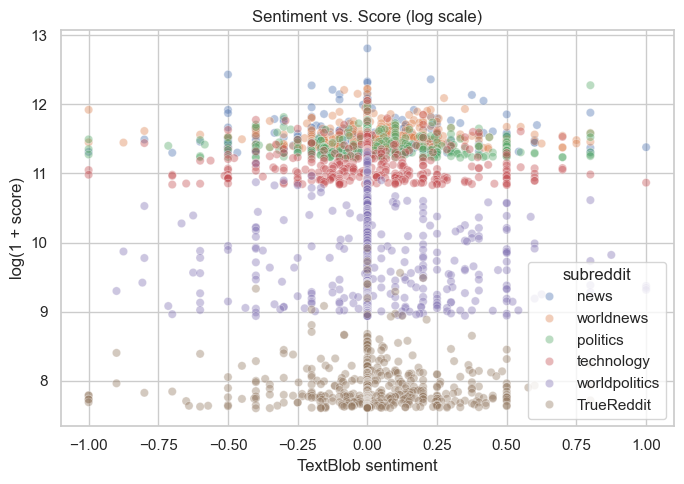

,sentiment_polarity,score,num_comments
sentiment_polarity,1.000000,-0.030000,-0.070000
score,-0.030000,1.000000,0.780000
num_comments,-0.070000,0.780000,1.000000


In [16]:
# Scatter: sentiment vs. score 
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x='sentiment_polarity',
    y=np.log1p(df['score']),
    hue='subreddit',
    alpha=0.4
)
plt.title("Sentiment vs. Score (log scale)")
plt.xlabel("TextBlob sentiment")
plt.ylabel("log(1 + score)")
plt.tight_layout()
plt.show()

# Simple correlation table
corr = (
    df[['sentiment_polarity','score','num_comments']]
    .corr(method='spearman')        
    .round(2)
)
display(corr.style.background_gradient(cmap="coolwarm"))

**Insight**

**Does tone drive popularity?**

| Metric | ρ with sentiment polarity |
|--------|---------------------------|
| **Score** (up-votes) | **–0.03** |

The scatter-plot (polarity × score, log-scale) shows a dense vertical band at
`sentiment ≈ 0` with no upward or downward tilt; the numeric correlation of
-0.03 confirms what we see:

* **Neutral headlines dominate**; extreme positive/negative titles are rare.  
* **Engagement is tone-agnostic** in this data-set — topic and subreddit size
  matter far more than TextBlob sentiment.

> Take-away: making a headline happier or angrier is unlikely to boost its
> score; content selection and community fit are the real levers.

### Posting-Hour Heat-Map (UTC)

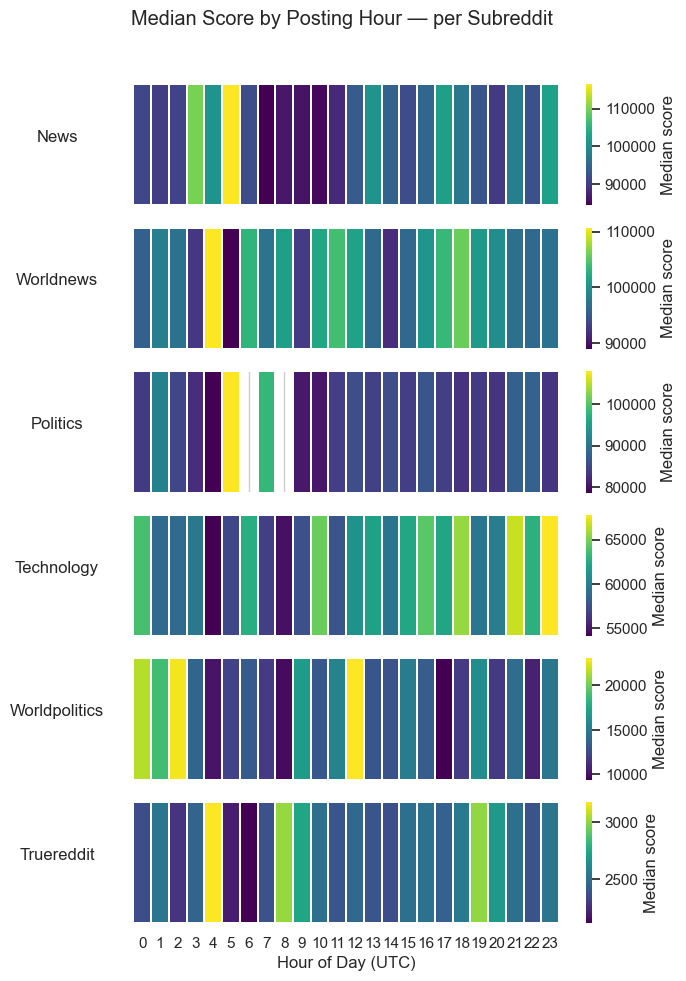

In [14]:
df['hour_utc'] = pd.to_datetime(df['created_date']).dt.hour

subs = df['subreddit'].unique()
fig, axs = plt.subplots(len(subs), 1,
                        figsize=(7, 1.6*len(subs)),
                        sharex=True)

for ax, sub in zip(axs, subs):
    # pivot without filling; NaNs remain
    p = (df[df['subreddit'] == sub]
           .pivot_table(index='hour_utc',
                        values='score', aggfunc='median')
           .reindex(range(24)))           # hours 0-23, NaN where no posts
    
    # build heat-map, masking NaN
    sns.heatmap(p.T, cmap='viridis',
                mask=p.T.isna(),
                ax=ax,
                cbar_kws={'label':'Median score'},
                linewidths=.3)
    
    ax.set_ylabel(sub.replace('_',' ').title(), rotation=0, labelpad=55)
    ax.set_xlabel(''); ax.set_yticks([])

axs[-1].set_xlabel('Hour of Day (UTC)')
fig.suptitle('Median Score by Posting Hour — per Subreddit', y=1.02)
plt.tight_layout(); plt.show()

**Insight**

Posting hour has *minor* influence compared with topic and subreddit size. A small early-UTC window (roughly US evening / EU night) yields the best medians for most news-oriented subs, but gains are modest—timing alone won’t make a headline go viral.